In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from nengo.solvers import LstsqL2
from nengo_extras.plot_spikes import plot_spikes

import pystorm
from pystorm.hal import HAL
from pystorm.hal.net_builder import NetBuilder
from pystorm.hal.run_control import RunControl
from pystorm.hal.data_utils import lpf, bin_to_spk_times

In [2]:
def get_snr_gamma(lamtau_out, k):
    """SNR of the synaptically filtered gamma process

    In terms of the output lambda * tau
    """
    if isinstance(lamtau_out, float):
        lamtau_out = np.array([lamtau_out])
    lamtau_in = lamtau_out * k
    snr = np.zeros_like(lamtau_out)
    idx = lamtau_out > 0
    x = lamtau_in
    a = np.sqrt(2*x[idx])
    b_num = (1+x[idx])**k+x[idx]**k
    b_den = (1+x[idx])**k-x[idx]**k
    b = b_num/b_den
    c = 2*x[idx]/k
    snr[idx] = a / np.sqrt(k*(b-c))
    return snr

In [3]:
# set parameters for network
X = 16
Y = 8
NNEURON = X*Y
DIM = 1
FMAX = 1000

DOWNSTREAM_NS = 10000

hal = pystorm.hal.HAL()

In [4]:
net_builder = NetBuilder(hal)

def build_taps(net_builder):
    bad_syn = hal.get_calibration("synapse", "high_bias_magnitude")
    SX = X // 2
    SY = Y // 2
    tap_matrix_syn = net_builder.create_default_yx_taps(SY, SX, DIM, bad_syn)
    tap_matrix = net_builder.syn_taps_to_nrn_taps(tap_matrix_syn)
    np.savetxt("tap_matrix.txt", tap_matrix)
    return tap_matrix

tap_matrix = build_taps(net_builder)

In [5]:
def build_net(net_builder, tap_matrix):
    gain_divs = np.loadtxt("gain_divisors.txt", dtype=int)
    biases = np.loadtxt("biases.txt", dtype=int)

    d_matrix = np.zeros((Y*X+1, Y*X))
    d_matrix[:-1] = np.eye(Y*X)
    net = net_builder.create_single_pool_net(
        Y, X, tap_matrix, biases=biases, gain_divs=gain_divs, decoders=d_matrix)
    return net

net = build_net(net_builder, tap_matrix)
run_control = RunControl(hal, net)
hal.map(net)

Collect data for training

[73.6036115]


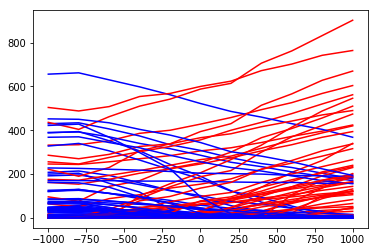

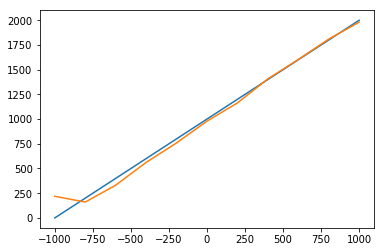

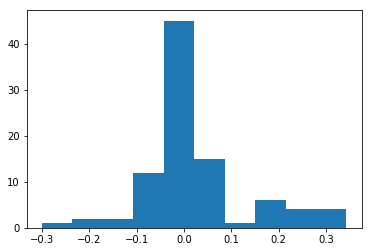

In [6]:
def train_decoders(hal, fmax):
    bin_size = 0.5 # seconds
    bin_size_ns = int(bin_size*1E9)
    hal.set_time_resolution(DOWNSTREAM_NS, bin_size_ns)

    total_train_points = 11
    offset_time = 1.
    offset_time_ns = int(offset_time*1E9)

    train_rates = np.zeros((total_train_points+2, 1))
    train_rates[1:total_train_points+1,0] = fmax * np.linspace(-1, 1, total_train_points)
    train_rates[0, 0] = train_rates[1, 0]
    train_rates[-1, 0] = train_rates[-2, 0]

    train_time_ns = np.arange(total_train_points+2)*bin_size_ns+offset_time_ns

    input_vals = {net.input:(train_time_ns, train_rates)}

    output_data, spike_data = run_control.run_input_sweep(
        input_vals, get_raw_spikes=True, get_outputs=True)
    spikes, bin_times = spike_data
    outputs, output_times = output_data
    outputs = outputs[net.output][1:, :-1]
    rates = outputs/bin_size
    train_rates = train_rates[1:-1]
    
    def plot_tuning(inputs, rates, array_width, array_height):
        nsq = array_width*array_height
        half_width = array_width//2
        for idx in range(array_height):
            start_l = idx*array_width
            start_r = start_l + half_width
            plt.plot(inputs, rates[:, start_l:start_l+half_width], 'r')
            plt.plot(inputs, rates[:, start_r:start_r+half_width], 'b')
    plot_tuning(train_rates, rates, X, Y)
    
    def fit_decoders(rates, target_function):
        solver = LstsqL2(reg=0.1)
        decoders, info = solver(rates, target_function)
        rmse = info['rmses']
        print(rmse)
        return decoders
    
    target_function = train_rates + FMAX
    decoders = fit_decoders(rates, target_function)

    z_idx = np.searchsorted(train_rates[:, 0], 0)
    rates_0 = rates[z_idx]
    def plot_training(train_rates, target_function, rates, decoders):
        train_decode = np.dot(rates, decoders)
        plt.figure()
        plt.plot(train_rates, target_function)
        plt.plot(train_rates, train_decode)

        plt.figure()
        plt.hist(decoders[rates_0>0])
    
    plot_training(train_rates, target_function, rates, decoders.flatten())
    return decoders
    
decoders = train_decoders(hal, FMAX)

In [7]:
# run tests
def assign_decoders(net, decoders, hal):
    net.decoder_conn.weights[-1, :] = decoders
    net.decoder_conn.reassign_weights(net.decoder_conn.weights)
    hal.remap_weights()

assign_decoders(net, decoders.flatten(), hal)
hal.get_spikes()
hal.get_outputs()

#  deliver an input of 0
def run_test(hal, run_control, bin_size=0.0001):
    """Run a single input test trial"""
    bin_size_ns = int(bin_size*1E9)
    hal.set_time_resolution(DOWNSTREAM_NS, bin_size_ns)

    offset_time = 0.2
    offset_time_ns = int(offset_time*1E9)

    test_time = 1
    test_time_ns = int(test_time*1E9)

    input_rates = np.zeros((2, 1))
    input_times = np.arange(2)*test_time_ns + offset_time_ns

    input_vals = {net.input:(input_times, input_rates)}
    output_data, _ = run_control.run_input_sweep(
        input_vals, get_raw_spikes=False, get_outputs=True)

    outputs, bin_times_ns = output_data
    outputs = outputs[net.output]
    decode = outputs[:, -1]
    spikes = outputs[:, :-1]
    
    bin_times = bin_times_ns * 1E-9
    bin_times -= bin_times[0]
    return decode, spikes, bin_times
decode, spikes, bin_times = run_test(hal, run_control)

In [8]:
# process output data
def check_decode(decode):
    bins_gt0 = np.sum(decode>0)
    total_outputs = np.sum(decode)
    bins_1 = np.sum(decode==1)
    bins_2 = np.sum(decode==2)
    bins_gt2 = np.sum(decode>2)
    bin_vals_gt2 = np.unique(decode[decode>2])
    print("Collected {:d} non-zero output bins. Sum(outputs) = {:d}".format(bins_gt0, total_outputs))
    print("Bin stats:1-spike bins: {:d}, 2-spike bins: {:d}, >2-spike bins: {:d} (bin values {})".format(
        bins_1, bins_2, bins_gt2, bin_vals_gt2))
check_decode(decode)

Collected 1204 non-zero output bins. Sum(outputs) = 1204
Bin stats:1-spike bins: 1204, 2-spike bins: 0, >2-spike bins: 0 (bin values [])


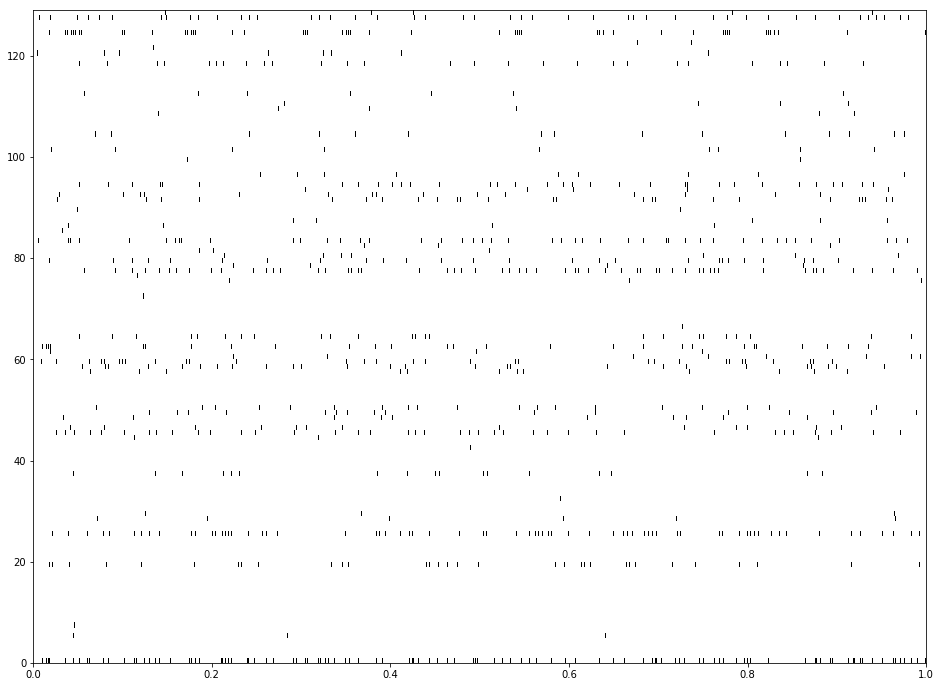

In [9]:
# make a raster of spikes and outputs
to_raster = np.zeros((decode.shape[0], 1+spikes.shape[1]))
to_raster[:, :-1] = spikes
to_raster[:, -1] = decode
to_raster[to_raster>1] = 1
plt.subplots(figsize=(16, 12))
plot_spikes(bin_times, to_raster)

In [10]:
dt = bin_times[1] - bin_times[0]
tau = 0.01

valid_decode = decode.copy()
valid_decode[decode>10] = 0
filtered_decode = lpf(valid_decode, tau, dt)

filtered_spikes = lpf(spikes, tau, dt)
decoded_spikes = spikes*decoders[:, 0]
filtered_decoded_spikes = lpf(decoded_spikes, tau, dt)
decode = np.sum(filtered_decoded_spikes, axis=1)

26.434807233190142


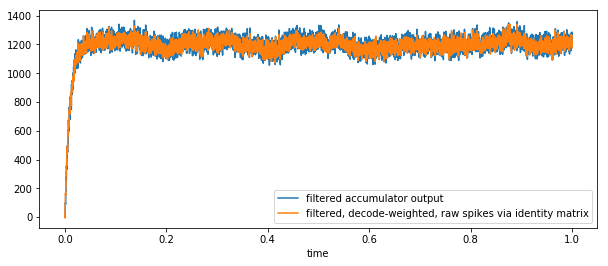

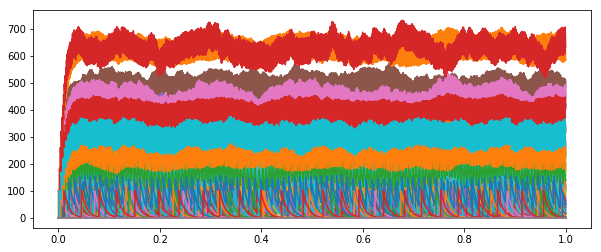

In [11]:
mean = np.mean(filtered_decode[bin_times>5*tau])
var = np.var(filtered_decode[bin_times>5*tau])
print(mean/np.sqrt(var))

plt.subplots(figsize=(10,4))
plt.plot(bin_times, filtered_decode, label="filtered accumulator output")
plt.plot(bin_times, decode, label="filtered, decode-weighted, raw spikes via identity matrix")
plt.legend(loc="best")
plt.xlabel("time")

plt.subplots(figsize=(10,4))
for idx in range(X*Y):
    plt.plot(bin_times, filtered_spikes[:, idx])

### open ideas

- compare to all weights positive and equal
- check for poissonness of superposed spike trains
- sweep decoder magnitude

In [12]:
TAU = 0.01

class DData:
    def __init__(self, decode, spikes, bin_times):
        self.decode = decode
        self.spikes = spikes
        self.bin_times = bin_times
    
def dw_sweep_collect_data(dweights, net, run_control, hal):
    """Collect data from experiments that sweep across dweights"""
    dw_data = {}
    for dw in dweights:
        assign_decoders(net, dw, hal)
        decode, spikes, bin_times = run_test(hal, run_control)
        dw_data[dw] = DData(decode=decode, spikes=spikes, bin_times=bin_times)
    return dw_data

# dweights = [1, 1/2, 1/4, 1/8, 1/16, 1/32, 1/64]
dweights = [1, 1/2, 1/4]
ddata = dw_sweep_collect_data(dweights, net, run_control, hal)

In [13]:
def dw_sweep_analyze_data(ddata):
    for dw in ddata:
        decode = ddata[dw].decode
        spikes = ddata[dw].spikes
        bin_times = ddata[dw].bin_times
        dt = bin_times[1] - bin_times[0]
        filtered_decode = lpf(decode, TAU, dt)
        idx = bin_times>5*TAU
        fin = np.sum(spikes[idx]) / (bin_times[idx][-1] - bin_times[idx][0])
        fout = np.sum(decode[idx]) / (bin_times[idx][-1] - bin_times[idx][0])
        mean = np.mean(filtered_decode[idx])
        var = np.var(filtered_decode[idx])
        snr = mean/np.sqrt(var)
        print("dw {} fin {:.0f} fout {:.0f} mean {:.0f} var {:.0f} snr {:.2f}".format(
            dw, fin, fout, mean, var, snr))
        ddata[dw].filtered_decode = filtered_decode
        ddata[dw].fin, ddata[dw].fout = (fin, fout)
        ddata[dw].mean, ddata[dw].snr = (mean, snr)
        ddata[dw].dspk_times = bin_to_spk_times(decode, bin_times)
    return ddata
ddata = dw_sweep_analyze_data(ddata)

dw 1 fin 8797 fout 8797 mean 8793 var 70313 snr 33.16
dw 0.5 fin 8754 fout 4378 mean 4374 var 18778 snr 31.92
dw 0.25 fin 8732 fout 2184 mean 2183 var 4851 snr 31.35


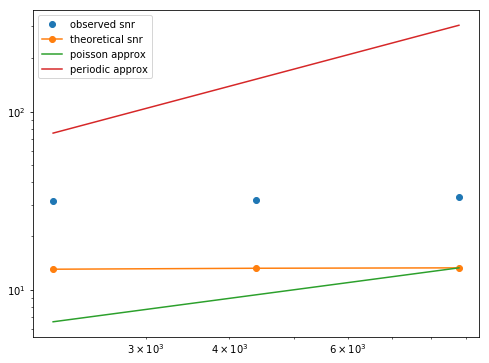

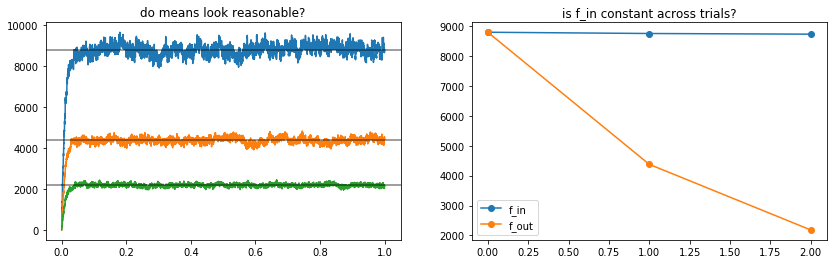

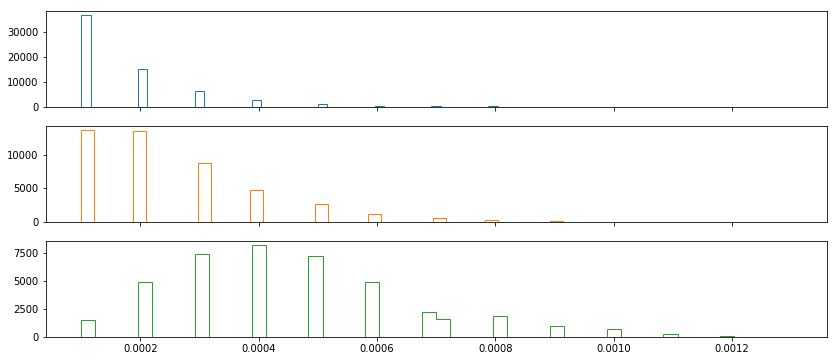

In [14]:
def dw_sweep_plot_data(ddata):
    snr_fig, snr_ax = plt.subplots(figsize=(8, 6))
    exp_fig, exp_axs = plt.subplots(ncols=2, figsize=(14,4))
    ax_filt, ax_f = exp_axs
    hist_fig, hist_axs = plt.subplots(nrows=len(ddata), figsize=(14, 2*len(ddata)), sharex=True)
    
    fout = np.zeros(len(ddata))
    fin = np.zeros(len(ddata))
    snr = np.zeros(len(ddata))
    snr_th = np.zeros(len(ddata))
    for idx, dw in enumerate(ddata):
        color = ax_filt.plot(ddata[dw].bin_times, ddata[dw].filtered_decode)[0].get_color()
        ax_filt.axhline(ddata[dw].mean, color="k", alpha=0.5)
        fin[idx] = ddata[dw].fin
        fout[idx] = ddata[dw].fout
        snr[idx] = ddata[dw].snr
        snr_th[idx] = get_snr_gamma(ddata[dw].fout*TAU, 1/dw)
        isi = np.diff(ddata[dw].dspk_times)
        hist_axs[idx].hist(isi, bins=50, cumulative=False, density=True, histtype="step", color=color)

    ax_filt.set_title('do means look reasonable?')
    fends = np.array([fout.min(), fout.max()])
    snr_poi = np.sqrt(2*fends*TAU)
    snr_per = np.sqrt(12)*fends*TAU

    snr_ax.loglog(fout, snr, 'o', label="observed snr")
    snr_ax.loglog(fout, snr_th, '-o', label="theoretical snr")
    snr_ax.loglog(fends, snr_poi, label="poisson approx")
    snr_ax.loglog(fends, snr_per, label="periodic approx")
    snr_ax.legend(loc="best")

    ax_f.plot(fin, '-o', label="f_in")
    ax_f.plot(fout, '-o', label="f_out")
    ax_f.legend(loc="best")
    ax_f.set_title("is f_in constant across trials?")
    
#     plot gamma function with same color
#     plot exponential function with same color
dw_sweep_plot_data(ddata)

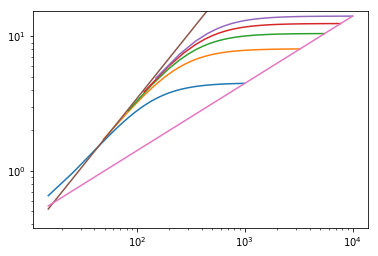

In [15]:
def th_sweep():
    fins = np.linspace(1000, 10000, 5)
    dweights = np.linspace(0.015, 1, 100)
    fouts = np.zeros((len(dweights), len(fins)))
    routs = np.zeros_like(fouts)
    plt.figure()
    for fidx, fin in enumerate(fins):
        for didx, dw in enumerate(dweights):
            fouts[didx, fidx] = fin*dw
            routs[didx, fidx] = get_snr_gamma(fouts[didx, fidx]*TAU, 1/dw)
        plt.loglog(fouts[:, fidx], routs[:, fidx])
    fends = np.array([fouts.min(), fouts.max()])
    r_uni = np.sqrt(12)*fends*TAU
    r_poi = np.sqrt(2*fends*TAU)
    plt.loglog(fends, r_uni)
    plt.loglog(fends, r_poi)
    plt.ylim([plt.ylim()[0], 1.1*routs.max()])
th_sweep()